In [26]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.models import Model, load_model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

In [27]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []


In [28]:

class MyDataGenerator:
    images_dir = '../../datasets/celeba_images'
    
    def __init__(self, nb_images=None, valid_split=0.25, stride=1, color=True, flatten=False):
        self.color = color
        self.flatten = flatten
        self.slice = slice(0, None, stride)
        self.nb_images = nb_images or len(glob.glob(images_dir + '/*.jpg'))
        indices = np.arange(1, nb_images+1)
        spt = int(nb_images * (1.0 - valid_split))
        self.train_indices = indices[:spt]
        self.valid_indices = indices[spt:]
        self.original_shape = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, 1)).shape
        
    def __call__(self, batch_size, is_validation=False):
        indices = self.valid_indices if is_validation else self.train_indices
        nb_images = len(indices)
        nb_batches = int(np.ceil(nb_images / batch_size)) 
        while True:
            for i in range(nb_batches):
                i0 = i * batch_size
                i1 = i0 + batch_size
                images = []
                for j in indices[i0:i1]:
                    fn = '{}/{:06d}.jpg'.format(self.images_dir, j)
                    img = plot.imread(fn) / 255.0
                    images.append(img[self.slice, self.slice, :])
                images = np.array(images)
                if not self.color:
                    images = images.mean(-1)
                if self.flatten:
                    images = images.reshape(batch_size, -1)
                yield images, images

    def get_steps_per_epoch(self, batch_size, is_validation=False):
        indices = self.valid_indices if is_validation else self.train_indices
        nb_images = len(indices)
        batch_size = int(np.ceil(nb_images / batch_size)) 
        return batch_size
    
    def get_datum(self, index):
        img = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, index)) / 255.0
        img = img[self.slice, self.slice]
        if not self.color:
            image = img.mean(-1)
        if self.flatten:
            image = image.ravel()
        return np.array([image])
    
    def get_image(self, index):
        img = plot.imread('{}/{:06d}.jpg'.format(self.images_dir, index)) / 255.0
        img = img[self.slice, self.slice]
        if not self.color:
            image = img.mean(-1)
        return image
    

(218, 178, 3) 0.0 1.0


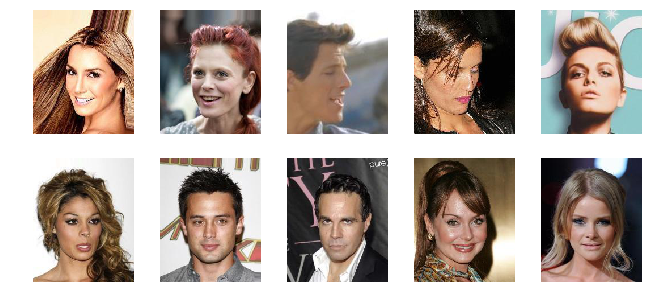

In [29]:
data = MyDataGenerator(1000)
gen = data(16)
aa, _ = next(gen)
print(aa[0].shape, aa[0].min(), aa[0].max())
figsize(11, 5)
for i in range(10):
    plot.subplot(2, 5, i+1)
    plot.imshow(aa[i])
    plot.axis('off')

In [30]:
N = 10000
batch_size = 50
stride = 2

data = MyDataGenerator(N, stride=stride, color=False, flatten=True)

original_image_shape = data.original_shape
train_steps = data.get_steps_per_epoch(batch_size)
valid_steps = data.get_steps_per_epoch(batch_size, True)

train_gen = data(batch_size)
valid_gen = data(batch_size, True)

flatten_dim = np.prod(original_image_shape[:-1]) // (stride * stride)
print(flatten_dim, train_steps, valid_steps)


9701 150 50


In [31]:
# http://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
    
latent_dim = 2
intermediate_dim = 512

# Q(z|X) -- encoder
inputs     = Input(shape=(flatten_dim,))
enc_hidden = Dense(intermediate_dim, activation='relu')(inputs)
enc_mean   = Dense(latent_dim, activation='linear')(enc_hidden)
enc_logvar = Dense(latent_dim, activation='linear')(enc_hidden)

def sample_z(args, batch_size=batch_size, latent_dim=latent_dim):
    enc_mean, enc_logvar = args
    # para usar a linha seguinte é preciso especificar batch_shape em Input
    # eps = K.random_normal(shape=enc_mean.shape, mean=0.0, stddev=1.0)
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
    return enc_mean + K.exp(enc_logvar / 2) * eps

# Sample z ~ Q(z|X)
enc_sampled = Lambda(sample_z)([enc_mean, enc_logvar])

# P(X|z) -- decoder
decoder_hidden_layer = Dense(intermediate_dim, activation='relu')
decoder_output_layer = Dense(flatten_dim, activation='sigmoid')

dec_hidden = decoder_hidden_layer(enc_sampled)
outputs    = decoder_output_layer(dec_hidden)

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, enc_mean)

# Generator model, generate new data given latent variable z
dec_in  = Input(shape=(latent_dim,))
dec_h   = decoder_hidden_layer(dec_in)
dec_out = decoder_output_layer(dec_h)
decoder = Model(dec_in, dec_out)


In [32]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    
    # Kullback–Leibler divergence
    # calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(enc_logvar) + K.square(enc_mean) - 1. - enc_logvar, axis=1)

    return recon + kl

vae.compile(optimizer='adam', loss=vae_loss)


In [33]:
trainIt = 1
model_weights_fn = '../../models/vae_celeba_01.weights'

if os.path.isfile(model_weights_fn):
    vae.load_weights(model_weights_fn)

if trainIt:
    nb_epochs = 10

    ckp = ModelCheckpoint(model_weights_fn, monitor='val_loss', 
                          save_weights_only=True, save_best_only=True, mode='min')

    try:
        vae.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=nb_epochs,
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=[ckp])
    except KeyboardInterrupt:
        print("Interrupted!")

Epoch 1/10
150/150 [==============================] - 66s - loss: 5810.7629 - val_loss: 5804.6056

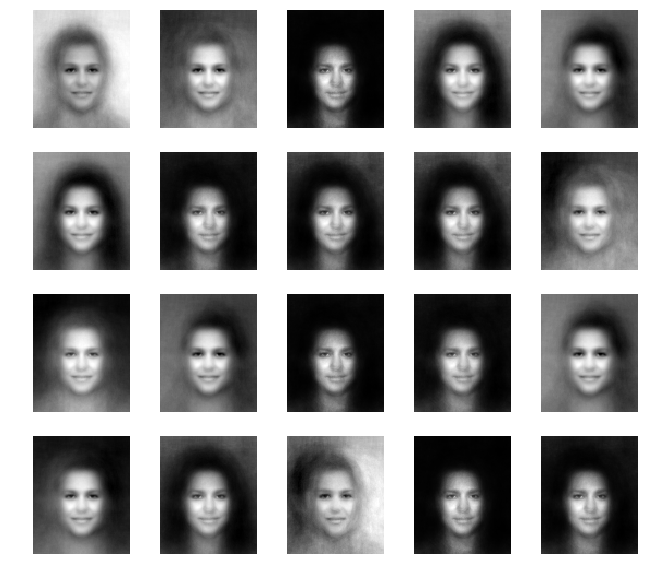

In [34]:
bs = 20
samples = nr.normal(0.0, 1.0, size=(bs, latent_dim))
aa = decoder.predict(samples, batch_size=bs)
bb = aa.reshape(bs, 109, 89)

figsize(11, 10)
for i, img in enumerate(bb):
    plot.subplot(4, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    

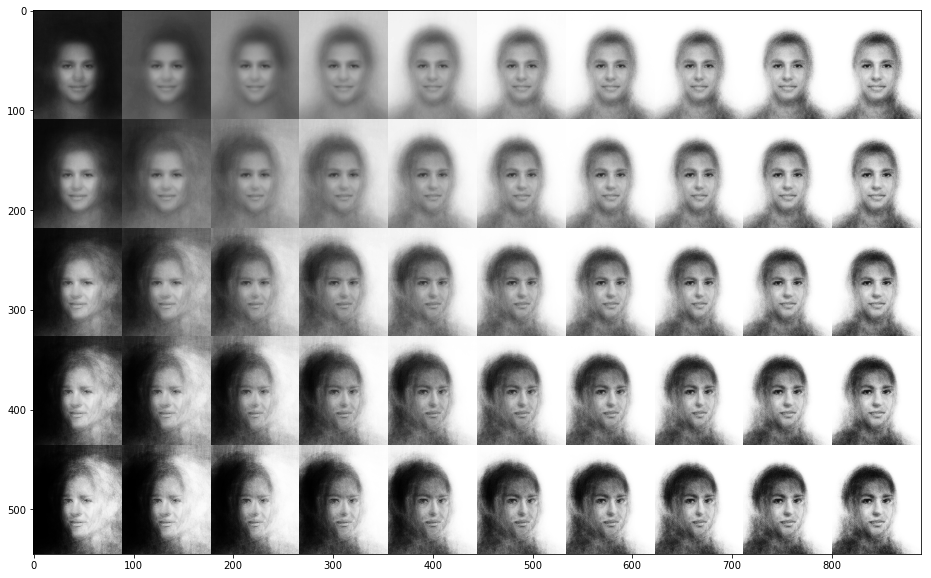

In [35]:
from scipy.stats import norm
nh, nw = 5, 10
hh, ww = 109, 89
figure = np.zeros((hh * nh, ww * nw))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, nw))
grid_y = norm.ppf(np.linspace(0.05, 0.95, nh))

grid_x = np.linspace(0.0, 10.0, nw)
grid_y = np.linspace(0.0, 10.0, nh)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        face = x_decoded[0].reshape(109, 89)
        figure[j * hh: (j + 1) * hh, i * ww: (i + 1) * ww] = face

plot.figure(figsize=(20, 10))
plot.imshow(figure, cmap='gray')


[[-1.504  2.057]] [[-1.504  2.057]] [[-2.962  1.474]]


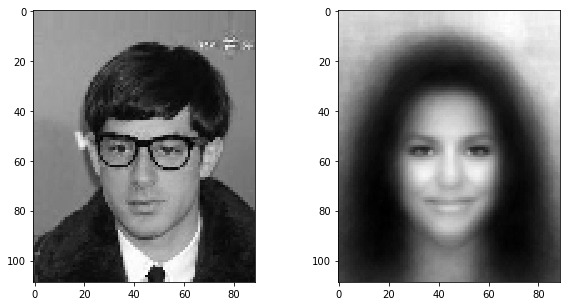

In [36]:
m = nr.randint(N)
img = data.get_datum(m).reshape(1, -1)
code1 = encoder.predict(img, batch_size=1)
code2 = encoder.predict(img, batch_size=1)

sampled = nr.normal(code1, 1)
print(code1, code2, sampled)

img1 = data.get_image(m)
img2 = decoder.predict(sampled).reshape(img1.shape)

figsize(10, 5)
plot.subplot(1, 2, 1)
plot.imshow(img1, cmap='gray')
plot.subplot(1, 2, 2)
plot.imshow(img2, cmap='gray')